<a href="https://colab.research.google.com/github/paezagustin/ML_2025/blob/main/Ejercicios_clase_3_3_spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score, f1_score, precision_score
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# **El ritmo de la música**
Este *dataset* está compuesto por canciones de 2017 con atributos de la API de Spotify. Cada canción ha sido etiquetada por alguien que usó "1", cuando le gusta la canción o "0" si no le gusta.

Su tarea es construir un clasificador que pueda predecir las preferencias de los atributos de la canción.

Cada fila del *dataframe* representa una canción. Hay 16 columnas, 13 de las cuales son atributos de la canción, una columna para el nombre de la canción, una para el artista y una columna llamada "destino", que es la etiqueta mencionada anteriormente para la canción. Los atributos de la pista son: acústica, bailabilidad, duración, energía, instrumentalidad, clave, vivacidad, volumen, modo, habla, tempo, marca de tiempo, valencia (más información[aquí](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)).

In [3]:
#leemos el dataset
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv",index_col=0)
df.describe()

acousticness  danceability   duration_ms       energy  \
count   2017.000000   2017.000000  2.017000e+03  2017.000000   
mean       0.187590      0.618422  2.463062e+05     0.681577   
std        0.259989      0.161029  8.198181e+04     0.210273   
min        0.000003      0.122000  1.604200e+04     0.014800   
25%        0.009630      0.514000  2.000150e+05     0.563000   
50%        0.063300      0.631000  2.292610e+05     0.715000   
75%        0.265000      0.738000  2.703330e+05     0.846000   
max        0.995000      0.984000  1.004627e+06     0.998000   

       instrumentalness          key     liveness     loudness         mode  \
count       2017.000000  2017.000000  2017.000000  2017.000000  2017.000000   
mean           0.133286     5.342588     0.190844    -7.085624     0.612295   
std            0.273162     3.648240     0.155453     3.761684     0.487347   
min            0.000000     0.000000     0.018800   -33.097000     0.000000   
25%            0.000000     2.000000     0.092300    -8.394000     0.000000   
50%            0.000076     6.000000     0.127000    -6.248000     1.000000   
75%            0.054000     9.000000     0.247000    -4.746000     1.000000   
max            0.976000    11.000000     0.969000    -0.307000     1.000000   

       speechiness        tempo  time_signature      valence       target  
count  2017.000000  2017.000000     2017.000000  2017.000000  2017.000000  
mean      0.092664   121.603272        3.968270     0.496815     0.505702  
std       0.089931    26.685604        0.255853     0.247195     0.500091  
min       0.023100    47.859000        1.000000     0.034800     0.000000  
25%       0.037500   100.189000        4.000000     0.295000     0.000000  
50%       0.054900   121.427000        4.000000     0.492000     1.000000  
75%       0.108000   137.849000        4.000000     0.691000     1.000000  
max       0.816000   219.331000        5.000000     0.992000     1.000000

Agarrar las mejores variables, buscar hiperparametros que maximicen el accuracy de validación

# Selección de variables con métricas

In [3]:
df

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0          0.01020         0.833       204600   0.434          0.021900    2   
1          0.19900         0.743       326933   0.359          0.006110    1   
2          0.03440         0.838       185707   0.412          0.000234    2   
3          0.60400         0.494       199413   0.338          0.510000    5   
4          0.18000         0.678       392893   0.561          0.512000    5   
...            ...           ...          ...     ...               ...  ...   
2012       0.00106         0.584       274404   0.932          0.002690    1   
2013       0.08770         0.894       182182   0.892          0.001670    1   
2014       0.00857         0.637       207200   0.935          0.003990    0   
2015       0.00164         0.557       185600   0.992          0.677000    1   
2016       0.00281         0.446       204520   0.915          0.000039    9   

      liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0       0.1650    -8.795     1       0.4310  150.062             4.0    0.286   
1       0.1370   -10.401     1       0.0794  160.083             4.0    0.588   
2       0.1590    -7.148     1       0.2890   75.044             4.0    0.173   
3       0.0922   -15.236     1       0.0261   86.468             4.0    0.230   
4       0.4390   -11.648     0       0.0694  174.004             4.0    0.904   
...        ...       ...   ...          ...      ...             ...      ...   
2012    0.1290    -3.501     1       0.3330   74.976             4.0    0.211   
2013    0.0528    -2.663     1       0.1310  110.041             4.0    0.867   
2014    0.2140    -2.467     1       0.1070  150.082             4.0    0.470   
2015    0.0913    -2.735     1       0.1330  150.011             4.0    0.623   
2016    0.2180    -6.221     1       0.1410  190.013             4.0    0.402   

      target                            song_title            artist  
0          1                              Mask Off            Future  
1          1                               Redbone  Childish Gambino  
2          1                          Xanny Family            Future  
3          1                        Master Of None       Beach House  
4          1                        Parallel Lines       Junior Boys  
...      ...                                   ...               ...  
2012       0   Like A Bitch - Kill The Noise Remix    Kill The Noise  
2013       0                                 Candy    Dillon Francis  
2014       0  Habit - Dack Janiels & Wenzday Remix          Rain Man  
2015       0                         First Contact        Twin Moons  
2016       0                    I Wanna Get Better         Bleachers  

[2017 rows x 16 columns]

In [ ]:
# Aplicar curva ROC y calcular AUC a cada variable
X = df.drop(columns=['target','song_title','artist'])
y = df['target']

df_variables = []
for column in X.columns:
    #ROC y AUC
    fpr,tpr, _ = roc_curve (y,X[column])
    roc_auc  = auc (fpr,tpr)

    # P-value
    grupo0 = X[y == 0][column]
    grupo1 = X[y == 1][column]
    _, p = ttest_ind (grupo0,grupo1,equal_var = False)

    # Balance Accuracy
    threshold = X[column].median()
    y_pred = (X[column] > threshold).astype(int)
    score = balanced_accuracy_score(y,y_pred)

    df_variables.append({"Variable": column, "AUC": roc_auc, "P-value": p, "BA": score})

df_variables = pd.DataFrame(df_variables)

In [41]:
df_variables.sort_values(by = ['P-value','AUC','BA'])

Variable       AUC       P-value        BA
1       danceability  0.614374  1.250859e-15  0.591008
9        speechiness  0.590690  3.079585e-12  0.551830
4   instrumentalness  0.654747  5.030458e-12  0.641072
2        duration_ms  0.580685  3.123015e-11  0.565703
0       acousticness  0.446474  5.824894e-09  0.455624
12           valence  0.562355  1.179291e-06  0.541902
8               mode  0.464754  1.145219e-03  0.500000
7           loudness  0.373051  1.281850e-03  0.392657
11    time_signature  0.509213  7.204355e-02  0.497836
3             energy  0.486157  7.579056e-02  0.486367
10             tempo  0.523187  1.193183e-01  0.518101
5                key  0.520193  1.314480e-01  0.516419
6           liveness  0.505486  2.361016e-01  0.515194

In [ ]:
#Voy probando variables según el dataframe anterior (BUSCAR COMBINATIONS, busqueda euristica )
X = df[['instrumentalness','danceability','speechiness','duration_ms','valence','loudness','acousticness']]
y = df['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

## KNN

In [43]:
# metricas
metrics = []
for k in [1,3,5,7,9,12,15]:
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled,y_train)
  y_pred = knn.predict(X_valid_scaled)
  metrics.append({'k': k,'Accuracy':accuracy_score(y_valid, y_pred),'F1 Score':f1_score(y_valid, y_pred),'Precision':precision_score(y_valid,y_pred)})

df_metrics = pd.DataFrame(metrics)
print(df_metrics)

    k  Accuracy  F1 Score  Precision
0   1  0.674102  0.681212   0.673861
1   3  0.706320  0.705590   0.715365
2   5  0.716233  0.715528   0.725441
3   7  0.702602  0.699248   0.715385
4   9  0.700124  0.695980   0.713918
5  12  0.698885  0.674699   0.743363
6  15  0.714994  0.703608   0.741848


# Validación cruzada a mano

In [ ]:
# Grid search (ver distintos hiperparametros que maximiza el accuracy)
from sklearn import neighbors
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd

X = df[['danceability','duration_ms','valence','loudness','acousticness']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=13)
data_metrics = []

for k in [1,3,5,7,9,12]:
    fold = 1
    for train_index, test_index in skf.split(X_train_scaled, y_train):

        X_train_skf, X_valid_skf = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_skf, y_valid_skf = y_train.iloc[train_index], y_train.iloc[test_index]

        knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_skf, y_train_skf)

        y_pred = knn.predict(X_valid_skf)
        df_valid = pd.DataFrame(X_valid_skf)
        df_valid['target'] = y_valid_skf.values
        df_valid['y_pred'] = y_pred


        acc = accuracy_score(df_valid['target'], df_valid['y_pred'])
        prec = precision_score(df_valid['target'], df_valid['y_pred'])
        f1_s = f1_score(df_valid['target'], df_valid['y_pred'])

        data_metrics.append({'k': k, 'fold': fold, 'acc': acc, 'prec': prec, 'f1_score': f1_s})
        fold += 1

df_metrics = pd.DataFrame(data_metrics)


## Estos resultados son sin normalizar los datos

In [ ]:
#X = df[['instrumentalness','danceability','speechiness','duration_ms','valence','loudness','acousticness']]
df_metrics['acc'].mean()

0.5717254665913243

In [37]:
#X = df[['instrumentalness','danceability','speechiness','duration_ms','energy','loudness','acousticness']]
df_metrics['acc'].mean()

0.5718079748421493

In [ ]:
#X = df[['instrumentalness','danceability','speechiness','duration_ms','loudness','acousticness']]
df_metrics['acc'].mean()

0.5717254665913243

In [41]:
#X = df[['danceability','speechiness','duration_ms','loudness','acousticness']]
df_metrics['acc'].mean()

0.5717254665913243

In [43]:
#X = df[['danceability','duration_ms','loudness','acousticness']]
df_metrics['acc'].mean()

0.5717254665913243

## Normalizando datos y separando correctamente los mismos

### K_skf = 5

In [40]:
#X = df[['instrumentalness','danceability','speechiness','duration_ms','valence','loudness','acousticness']]
df_metrics['acc'].mean()

0.6856857617188752

In [42]:
#X = df[['instrumentalness','danceability','speechiness','duration_ms','loudness','acousticness']]
df_metrics['acc'].mean()

0.6811296143171227

In [44]:
#X = df[['instrumentalness','danceability','speechiness','duration_ms','acousticness']]
df_metrics['acc'].mean()

0.6607724554352633

In [46]:
#X = df[['danceability','speechiness','duration_ms','valence','loudness','acousticness']]
df_metrics['acc'].mean()

0.6719461697722567

In [48]:
#X = df[['danceability','duration_ms','valence','loudness','acousticness']]
df_metrics['acc'].mean()

0.6555189123704402

### K_skf = 7

In [50]:
#X = df[['instrumentalness','danceability','speechiness','duration_ms','valence','loudness','acousticness']]
df_metrics['acc'].mean()

0.6867288680953278

In [52]:
#X = df[['instrumentalness','danceability','speechiness','duration_ms','loudness','acousticness']]
df_metrics['acc'].mean()

0.6898371469800041

In [54]:
#X = df[['instrumentalness','danceability','speechiness','duration_ms','acousticness']]
df_metrics['acc'].mean()

0.6598478126428436

In [56]:
#X = df[['danceability','speechiness','duration_ms','valence','loudness','acousticness']]
df_metrics['acc'].mean()

0.6725905909135723

In [58]:
#X = df[['danceability','duration_ms','valence','loudness','acousticness']]
df_metrics['acc'].mean()

0.6597608740465883

# Selección de variables con PCA

In [ ]:

X = df[['instrumentalness', 'loudness', 'speechiness', 'danceability', 'energy', 'duration_ms', 'acousticness']]
y = df['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# pca
#Elegi agarrar solo 5 variables porque me representaba muy buen porcentaje del dataset (cerca del 90%)
pca = PCA(n_components = 5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

## KNN

In [ ]:
# metricas

for k in [1,3,5,7,9,12,15]:
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X,y_train)

  y_pred = knn.predict(X_valid_pca)
  print("Para un k: ",k)
  print("Accuracy:", accuracy_score(y_valid, y_pred))
  print("F1 Score:", f1_score(y_valid, y_pred))
  print("Precision: ",precision_score(y_valid,y_pred))
  print("###")


Para un k:  1
Accuracy: 0.6654275092936803
F1 Score: 0.6699266503667481
Precision:  0.6682926829268293
###
Para un k:  3
Accuracy: 0.6951672862453532
F1 Score: 0.6932668329177057
Precision:  0.7055837563451777
###
Para un k:  5
Accuracy: 0.7075588599752168
F1 Score: 0.7057356608478803
Precision:  0.7182741116751269
###
Para un k:  7
Accuracy: 0.7162329615861215
F1 Score: 0.7104930467762326
Precision:  0.7336814621409922
###
Para un k:  9
Accuracy: 0.7063197026022305
F1 Score: 0.7026348808030113
Precision:  0.7197943444730077
###
Para un k:  12
Accuracy: 0.7149938042131351
F1 Score: 0.6925133689839572
Precision:  0.7617647058823529
###
Para un k:  15
Accuracy: 0.7100371747211895
F1 Score: 0.7007672634271099
Precision:  0.732620320855615
###


# Matriz de correlación

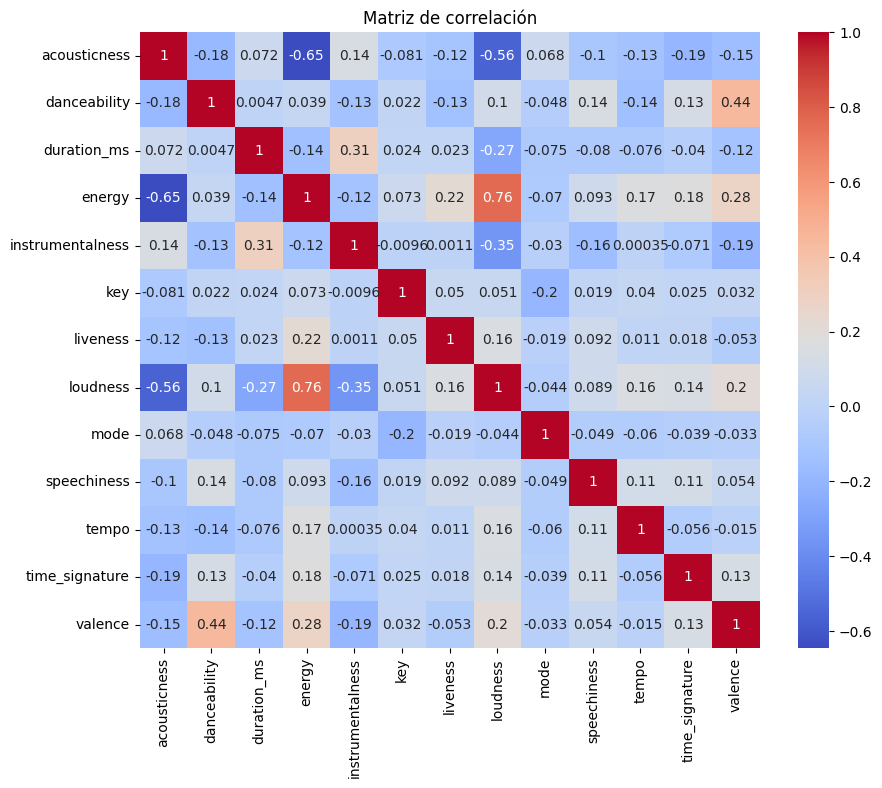

In [ ]:
df1 = df.drop(['target','song_title','artist'], axis=1)
corr = df1.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()


Hay una alta correlación entre energy y loudness, es posible dejar una sola de esas dos varaibles. A testear cuál me da mejores resultados

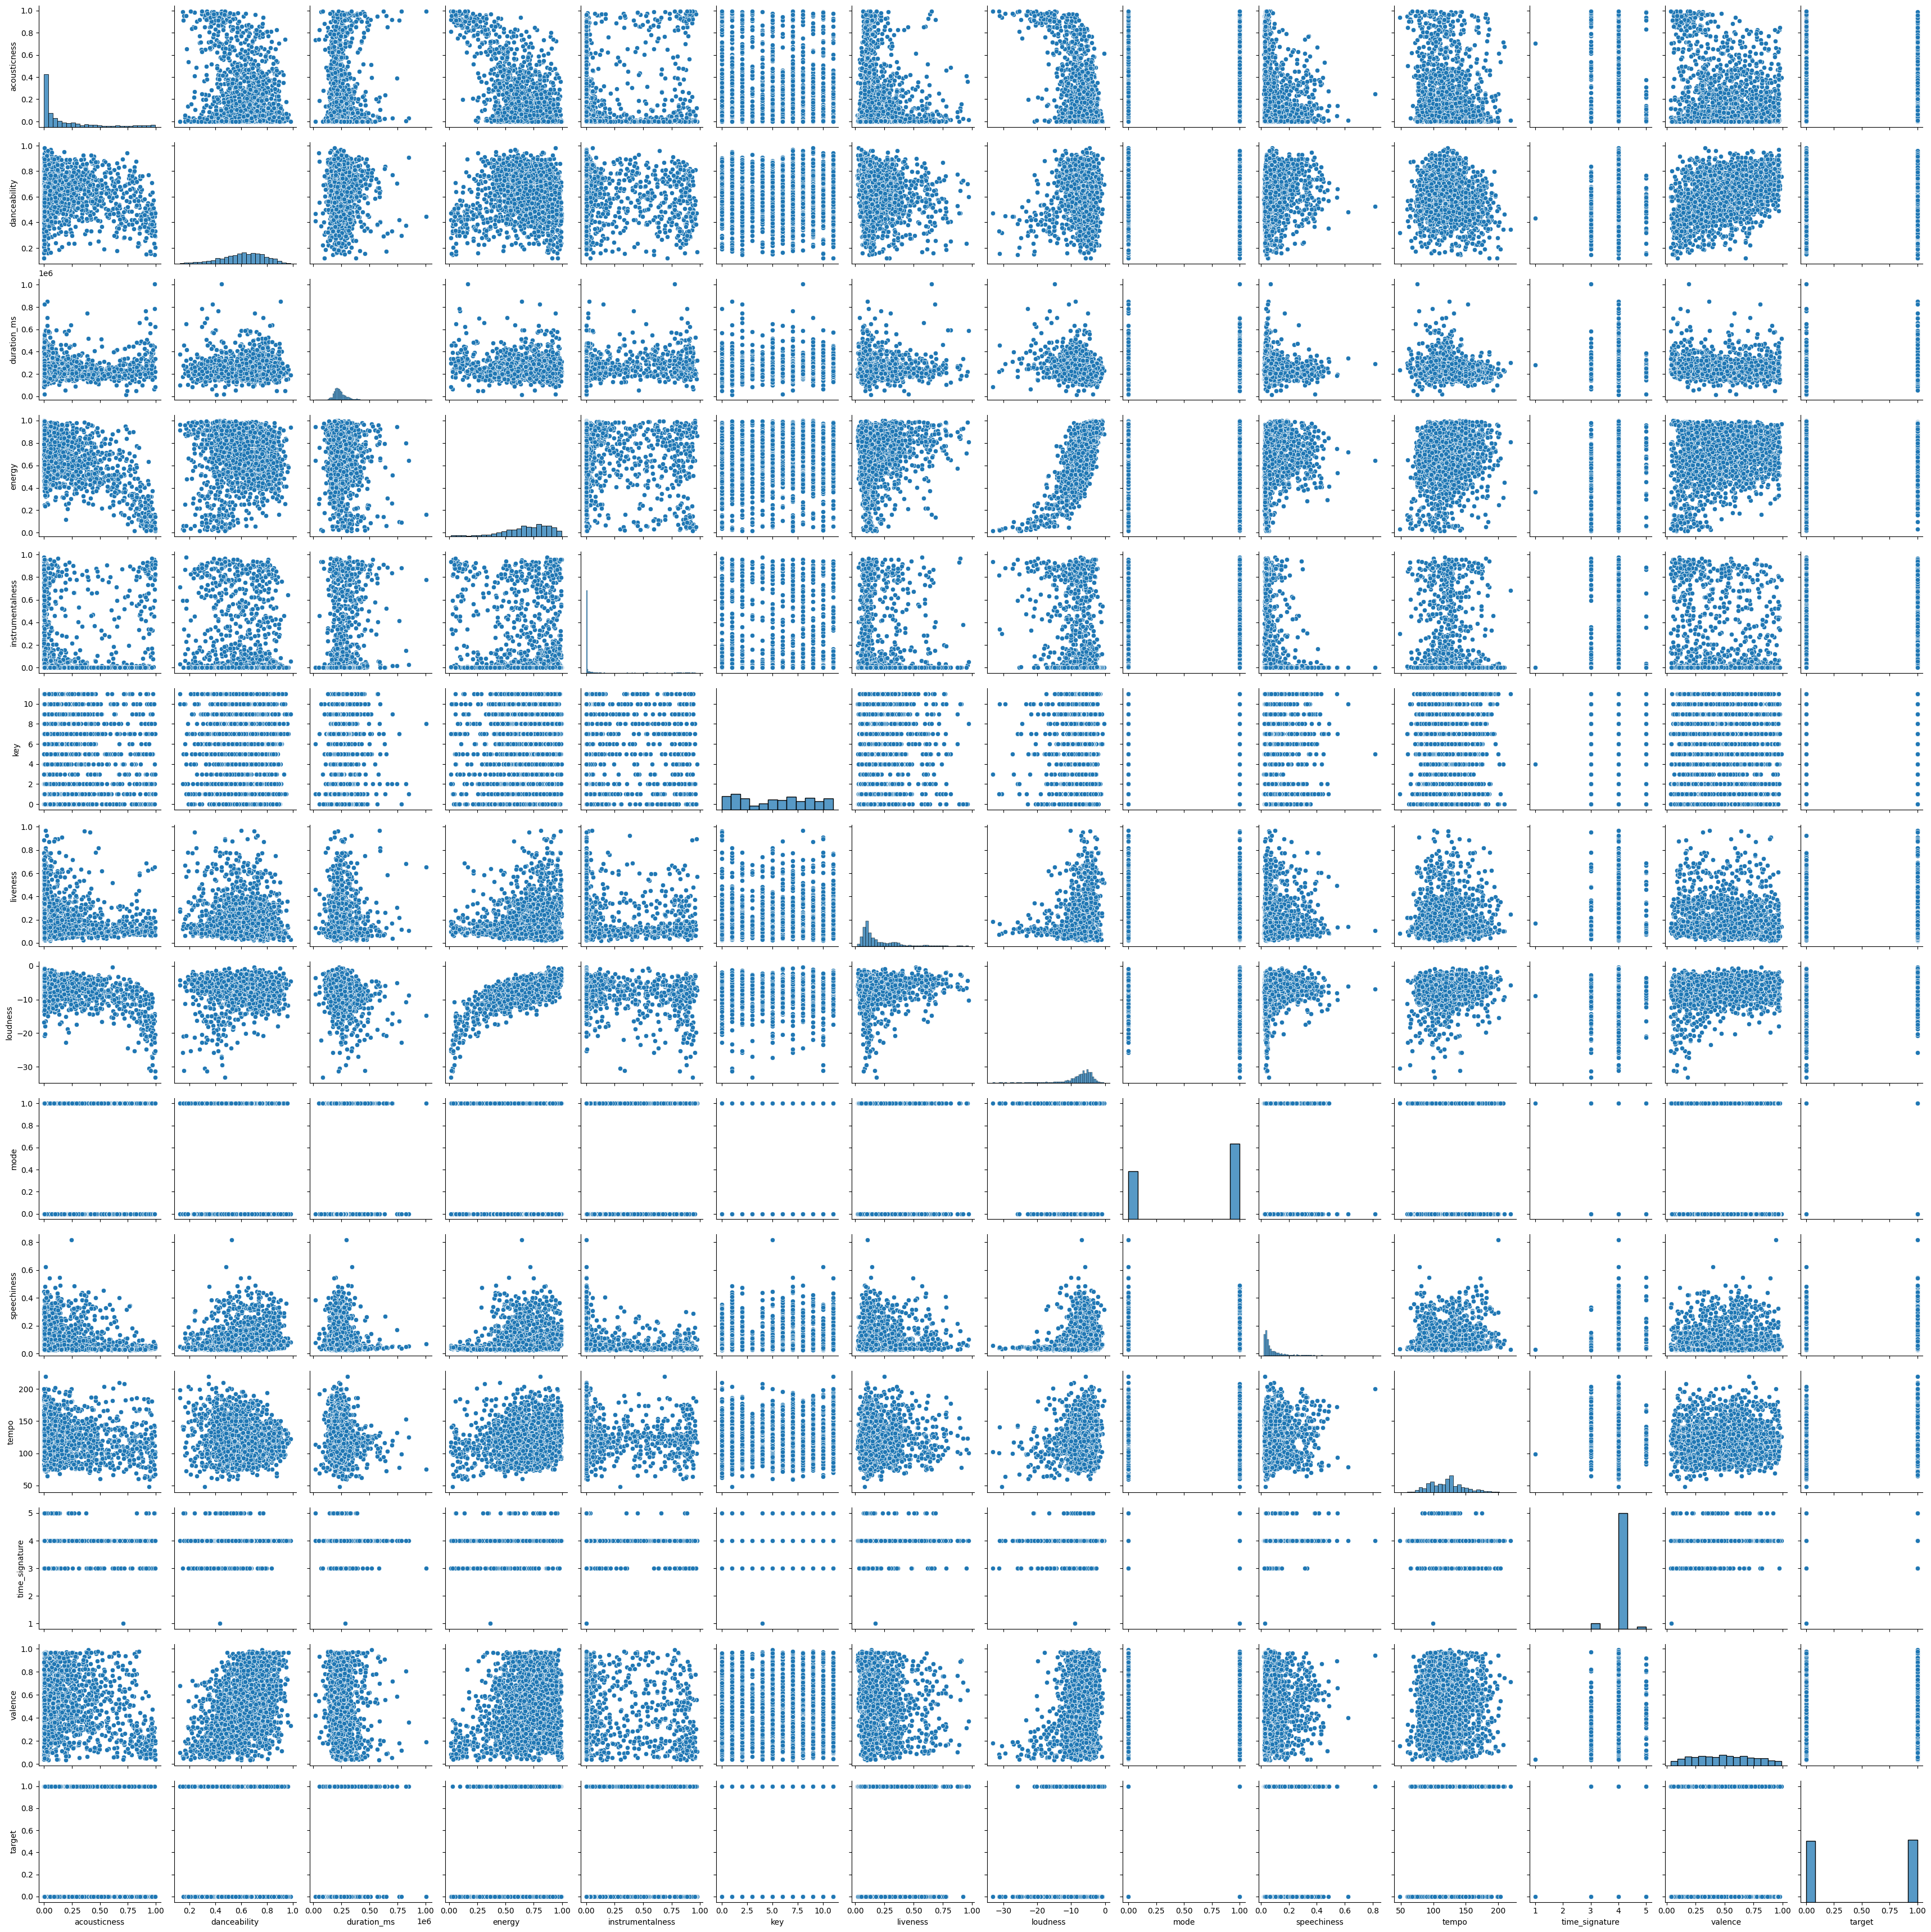

In [25]:
sns.pairplot(df)

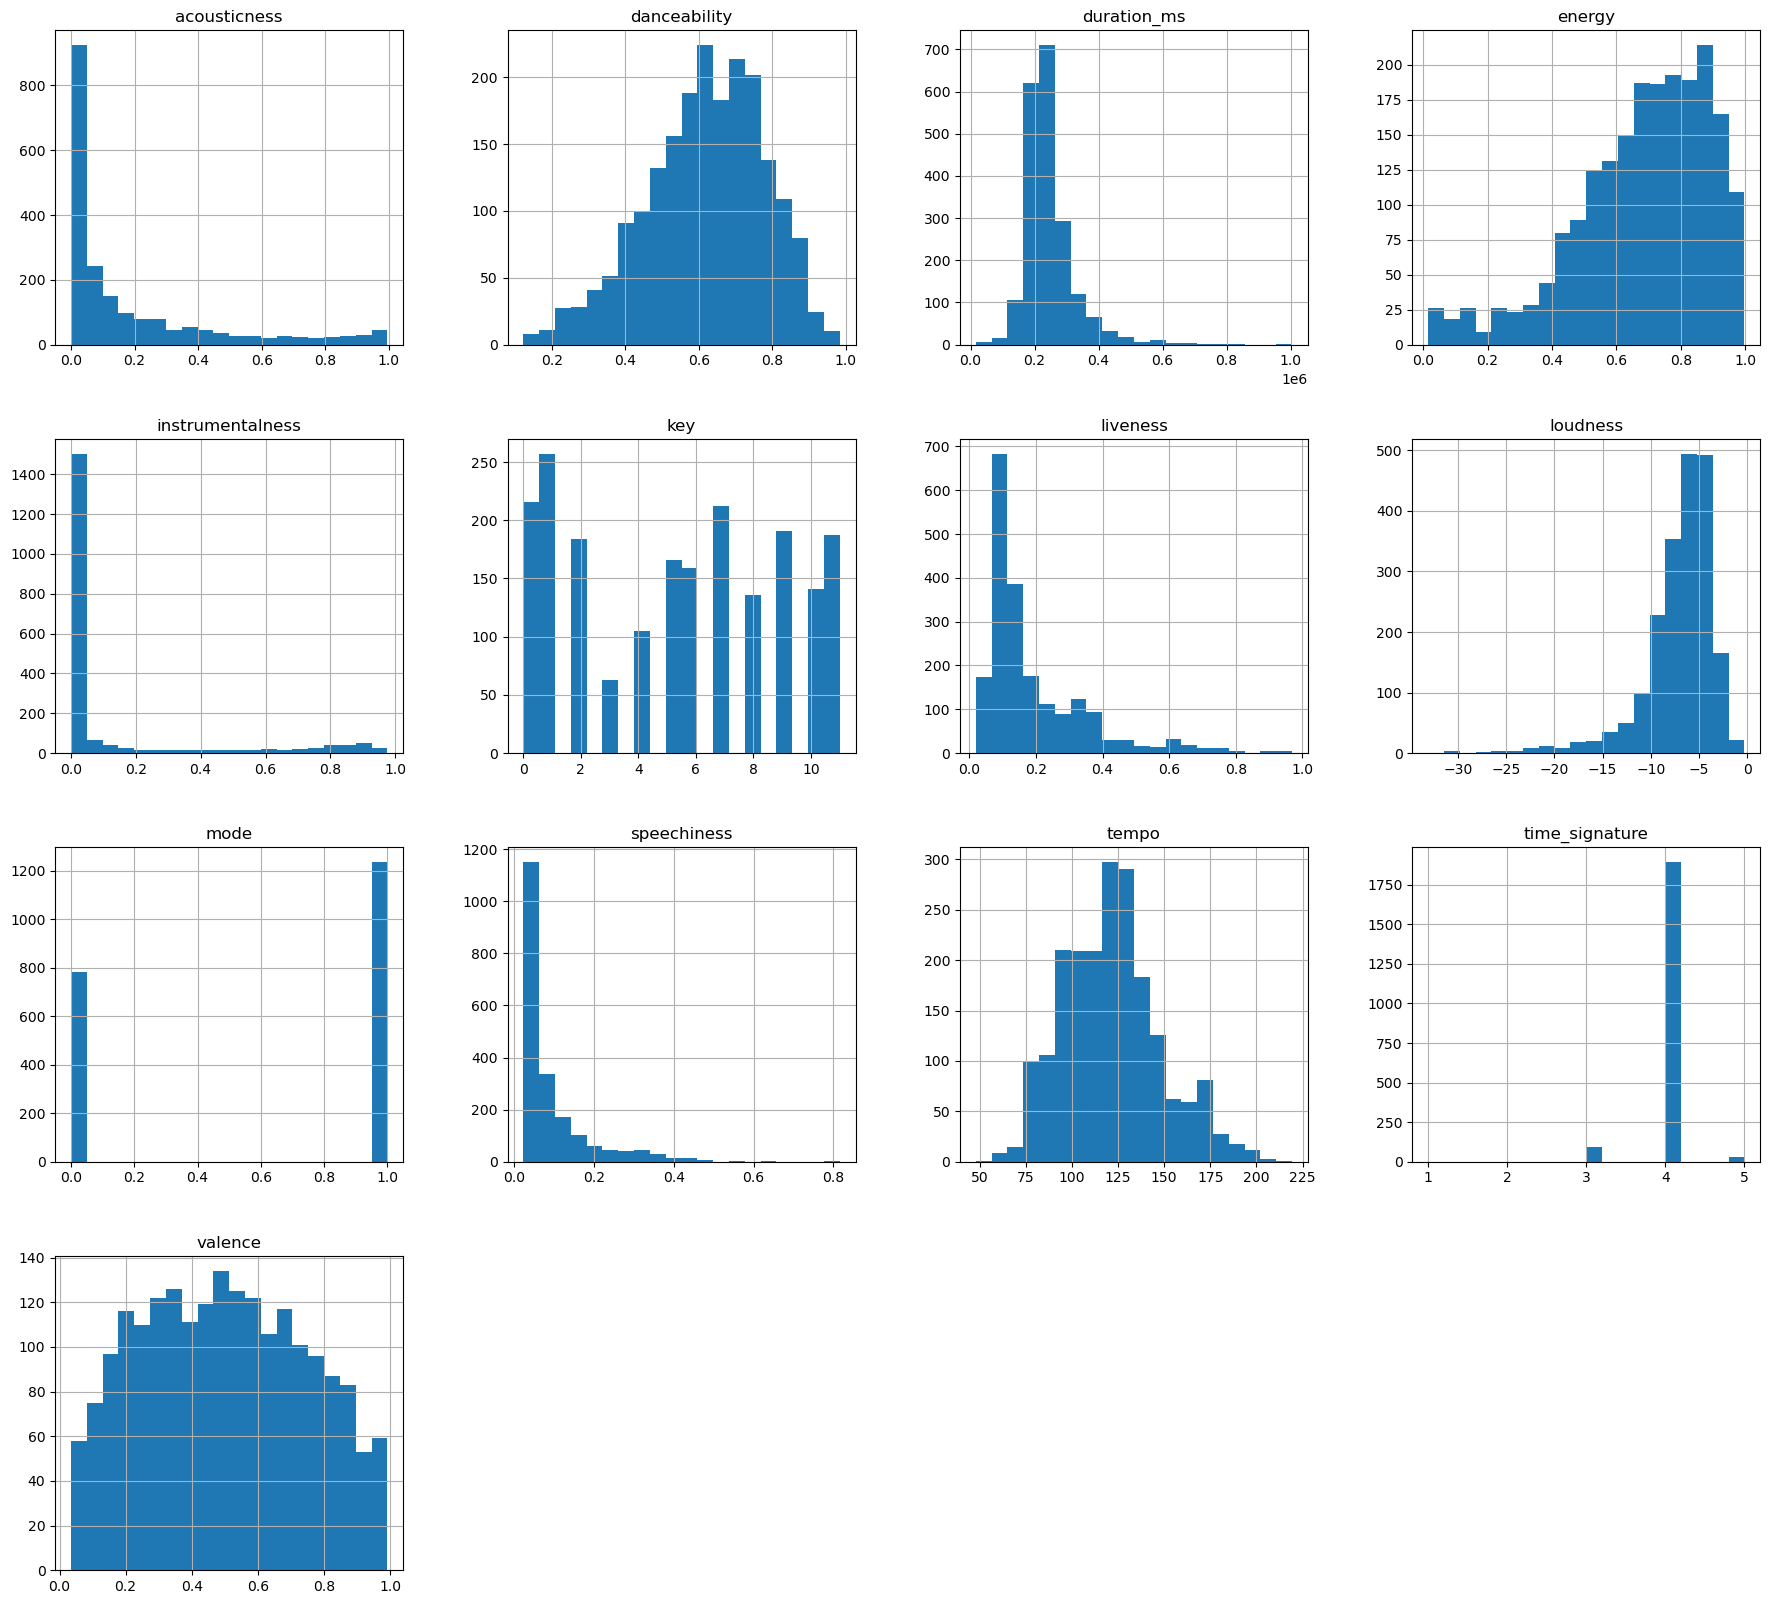

NameError: name 'p' is not defined

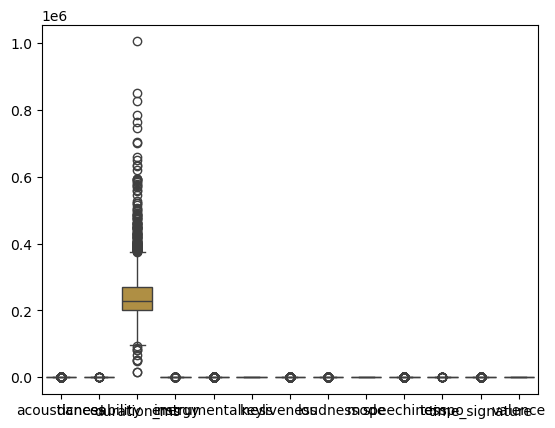

In [15]:
# Histograma para todas las características
df1 = df.drop(['target','song_title','artist'], axis=1)

scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)
df1_scaled = pd.DataFrame(df1,columns = df1.columns)

df1_scaled.hist(bins=20, figsize=(22, 20))
plt.show()

# Boxplot para detectar outliers
sns.boxplot(data=df1_scaled)
p
plt.show()


# Regularizacion lasso 

In [23]:
from sklearn.linear_model import Lasso,Ridge

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled,y_train)

print ("Coef Lasso: ", lasso.coef_)


Coef Lasso:  [ 0.06186642  0.0612221   0.06531121  0.03158305  0.03211362 -0.06527828
 -0.07581903]


In [22]:
#Utilizando GridSearch

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Definir el rango de alpha
param_grid = {'alpha': [0.01,0.025,0.05, 0.1]}

# Crear el modelo Lasso
lasso = Lasso()

# Realizar la búsqueda en grid con validación cruzada
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Ver los mejores parámetros
print(f"Mejor valor de alpha: {grid_search.best_params_}")


Mejor valor de alpha: {'alpha': 0.01}


# Busqueda de hiperparametros con GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np


X = df[['instrumentalness','danceability','speechiness','duration_ms','valence','loudness','acousticness']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

#X_train_scaled = pd.DataFrame(X_train_scaled,columns = X.columns)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier()


param_grid = {
    'n_neighbors': np.arange(1,100,1),  
    'metric': ['minkowski']  
}


grid_search = GridSearchCV(knn, param_grid, cv=7, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score de accuracy:", grid_search.best_score_)


Mejores parámetros: {'metric': 'minkowski', 'n_neighbors': 45}
Mejor score de accuracy: 0.7129762576967547
